# Problem statement

A lot has been said during the past several years about how precision medicine and, more concretely, how genetic testing is going to disrupt the way diseases like cancer are treated.

But this is only partially happening due to the huge amount of manual work still required. Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers).

Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

We are developing a Machine Learning algorithm that, using this knowledge base as a baseline and automatically classifies genetic variations.

This problem was launched by Memorial Sloan Kettering Cancer Center (MSKCC), accepted by NIPS 2017 Competition Track and determines the best model in terms of Log Loss

Data link for the problem: https://www.kaggle.com/c/msk-redefining-cancer-treatment


## Analysis of the problem statement

In [1]:
# Loading all required packages
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from chart_studio import plotly
from plotly import __version__
import plotly.graph_objs as go
import cufflinks as cf
cf.go_offline()
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

## Loading Data Files

In [2]:
# Loading training_variants. Its a comma seperated file
data_variants = pd.read_csv('training_variants')

# Loading training_text dataset. This is seperated by ||
data_text =pd.read_csv('training_text',sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [3]:
#Exploring data_variants
data_variants.head(10)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
5,5,CBL,V391I,4
6,6,CBL,V430M,5
7,7,CBL,Deletion,1
8,8,CBL,Y371H,4
9,9,CBL,C384R,4


DATA DESCRIPTION

ID : row id used to link the mutation to the clinical evidence

Gene : the gene where this genetic mutation is located

Variation : the aminoacid change for this mutations

Class : class value 1-9, this genetic mutation has been classified on


In [4]:
#Getting data information
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [5]:
#Description for numeric columns
data_variants.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [6]:
# Checking dimension of data
data_variants.shape

(3321, 4)

In [7]:
# Checking column in above data_variants
data_variants.columns

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')

In [8]:
# Exploring data_text
data_text.head(10)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...
5,5,Oncogenic mutations in the monomeric Casitas B...
6,6,Oncogenic mutations in the monomeric Casitas B...
7,7,CBL is a negative regulator of activated recep...
8,8,Abstract Juvenile myelomonocytic leukemia (JM...
9,9,Abstract Juvenile myelomonocytic leukemia (JM...


In [9]:
#Getting data information
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3321 non-null   int64 
 1   TEXT    3316 non-null   object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [10]:
# Description for numeric columns
data_text.describe()

,ID
count,3321.000000
mean,1660.000000
std,958.834449
min,0.000000
25%,830.000000
50%,1660.000000
75%,2490.000000
max,3320.000000


In [11]:
# Checking column in above data_text
data_text.columns

Index(['ID', 'TEXT'], dtype='object')

In [12]:
# Checking the dimensions
data_text.shape

(3321, 2)

# Datasets looks like this

data_variants (ID, Gene, Variations, Class)

data_text(ID, text)


In [13]:
# We are trying to predict the class of cancer,hence we will check all the unique values that can be determined
data_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

# This is discrete data so it is classification problem and since there are multiple descrete output possible so we can call it Multi class classification problem

## Important note : This is medical related problem so correct results are very important. Error can be really costly here so we would like to have result for each class in terms of Probablity. The latency can be compromised to some extent given that we want the minimal error rate possible.

We also want our model to be highly interpretable because a medical practitioner would want to provide proper reasonining on why an algorithm is predicting a soecific class.

We will evaluate our model using Confusion matrix and Multi class log-loss, we will also plot precision and recall matrix for better understanding of the prediction

In [17]:
# We would like to remove all stop words like a, is, an, the, ... so we are collecting all of them from nltk(Natural Language
# Toolkit) library
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\ANUJ
[nltk_data]     OJHA\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [18]:
def data_text_preprocess(total_text, ind, col):
    # Removing integer values from text data as that might not be important
    if type(total_text) is not int:
        string = ""
        # replacing all special characters with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replacing multiple spaces with single space
        total_text = re.sub('\s+',' ', str(total_text))
        # bringing the whole text to lower-case
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from text
            if not word in stop_words:
                string += word + " "
        
        data_text[col][ind] = string

In [19]:
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'], index, 'TEXT')

# Merging data_variants and data_text 

In [20]:
# Merging both gene_variations and text data based on ID
result = pd.merge(data_variants, data_text,on='ID', how='left')
result.head(10)

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...
5,5,CBL,V391I,4,oncogenic mutations monomeric casitas b lineag...
6,6,CBL,V430M,5,oncogenic mutations monomeric casitas b lineag...
7,7,CBL,Deletion,1,cbl negative regulator activated receptor tyro...
8,8,CBL,Y371H,4,abstract juvenile myelomonocytic leukemia jmml...
9,9,CBL,C384R,4,abstract juvenile myelomonocytic leukemia jmml...


# Cleaning the data, handling missing values

In [21]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


There are only five rows with missing data. 
This can be dealt in two ways:
1. Removing these rows
2. Using Imputation(replacing the null values)

The missing data is handled using imputation by replacing the null values with Gene and Variation

In [22]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [23]:
# Cross checking the null values after imputation
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


# Creating Training, Test and Validation data

Before splitting the data into training, test and validation data set. We want to ensure that all spaces in Gene and Variation column to be replaced by _.

In [24]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

In [25]:
# Splitting the data into train and test set 
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)

# split the train data now into train and cross validation
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [26]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


# Distribution of data in train, test and validation set

In [43]:
train_class_distribution = train_df['Class'].value_counts().sort_values
train_class_distribution

<bound method Series.sort_values of 7    609
4    439
1    363
2    289
6    176
5    155
3     57
9     24
8     12
Name: Class, dtype: int64>

In [50]:
df_train= pd.DataFrame(train_class_distribution)
df_train.iplot(kind = 'bar',xTitle='Class',yTitle='Data points',title = 'Train Class Distribution',color = 'pink')

ValueError: DataFrame constructor not properly called!

In [51]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

AttributeError: 'function' object has no attribute 'values'

In [52]:
test_class_distribution = test_df['Class'].value_counts().sort_values()
test_class_distribution

8      4
9      7
3     18
5     48
6     55
2     91
1    114
4    137
7    191
Name: Class, dtype: int64

In [53]:
df_train= pd.DataFrame(test_class_distribution)
df_train.iplot(kind = 'bar',xTitle='Class',yTitle='Data points',title = 'Test Class Distribution',color = 'red')

In [54]:
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

Number of data points in class 9 : 191 ( 28.722 %)
Number of data points in class 8 : 137 ( 20.602 %)
Number of data points in class 7 : 114 ( 17.143 %)
Number of data points in class 6 : 91 ( 13.684 %)
Number of data points in class 5 : 55 ( 8.271 %)
Number of data points in class 4 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 2 : 7 ( 1.053 %)
Number of data points in class 1 : 4 ( 0.602 %)


In [55]:
cv_class_distribution = cv_df['Class'].value_counts().sort_values()
cv_class_distribution

8      3
9      6
3     14
5     39
6     44
2     72
1     91
4    110
7    153
Name: Class, dtype: int64

In [101]:
df_train= pd.DataFrame(cv_class_distribution)
df_train.iplot(kind = 'bar',xTitle='Class',yTitle='Data points',title = 'Validation Class Distribution',color = 'blue')

In [98]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


Looking at the data point distribution for train, test and validation data we can safely say that the data distribution is similar in all the sets.

# For log-loss evaluation a random model is needed to compare the log loss against. Any successful model should return a lower log loss than this model

## Building a random model

In [102]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

### Log loss of validation set 

In [103]:
# Creating an output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))

for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

Log loss on Cross Validation Data using Random Model 2.462595691259592


### Log loss of test set

In [105]:
# Creating an output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

Log loss on Test Data using Random Model 2.5333496906287816


In [109]:
# Getting the index of max probablity
predicted_y =np.argmax(test_predicted_y, axis=1)

predicted_y

array([0, 1, 1, 3, 2, 1, 4, 4, 3, 2, 1, 5, 2, 1, 0, 4, 6, 1, 0, 1, 5, 4,
       8, 2, 0, 6, 0, 2, 5, 8, 3, 5, 1, 7, 6, 4, 0, 6, 7, 5, 2, 5, 7, 6,
       4, 2, 5, 3, 1, 2, 5, 7, 0, 2, 6, 4, 5, 0, 4, 5, 2, 6, 0, 5, 6, 7,
       0, 6, 2, 6, 0, 0, 4, 5, 3, 0, 6, 3, 4, 4, 5, 7, 1, 2, 5, 5, 0, 5,
       4, 2, 0, 8, 4, 8, 4, 3, 8, 2, 5, 0, 0, 0, 4, 5, 4, 4, 2, 5, 8, 8,
       3, 4, 4, 3, 2, 3, 8, 1, 4, 6, 0, 4, 8, 7, 5, 8, 0, 2, 2, 2, 8, 2,
       7, 7, 8, 1, 0, 0, 5, 8, 1, 8, 8, 8, 8, 5, 4, 0, 3, 6, 4, 6, 0, 5,
       7, 3, 6, 3, 5, 7, 4, 0, 0, 6, 3, 7, 2, 5, 3, 7, 6, 4, 2, 5, 1, 2,
       6, 5, 6, 6, 8, 6, 7, 3, 2, 6, 6, 4, 1, 0, 6, 2, 6, 5, 7, 6, 8, 5,
       3, 0, 5, 8, 3, 7, 3, 2, 7, 7, 1, 6, 4, 6, 2, 1, 0, 5, 3, 3, 3, 2,
       0, 1, 3, 0, 4, 0, 3, 8, 5, 3, 0, 0, 3, 6, 4, 1, 8, 5, 4, 2, 6, 8,
       6, 8, 4, 3, 2, 6, 1, 8, 2, 8, 4, 6, 3, 2, 5, 6, 2, 7, 3, 5, 2, 2,
       4, 2, 1, 7, 3, 3, 1, 0, 1, 6, 1, 1, 0, 2, 3, 4, 0, 7, 0, 6, 8, 5,
       1, 5, 3, 6, 2, 2, 0, 6, 1, 2, 4, 3, 3, 0, 5,

The index value ranges from 0 to 8. To rectify the value is increased by 1

In [110]:
predicted_y = predicted_y + 1

## Confusion Matrix

In [320]:
C = confusion_matrix(y_test, predicted_y)

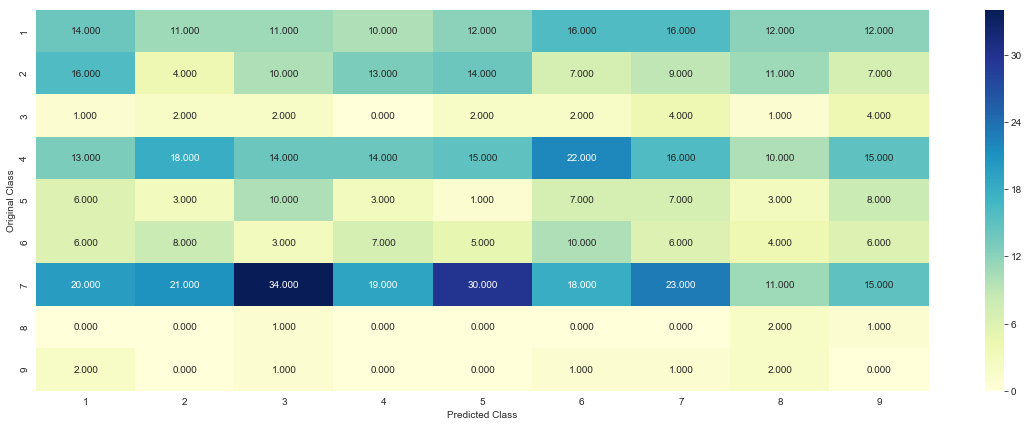

In [332]:
labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

## Precision Matrix

In [124]:
B =(C/C.sum(axis=0))

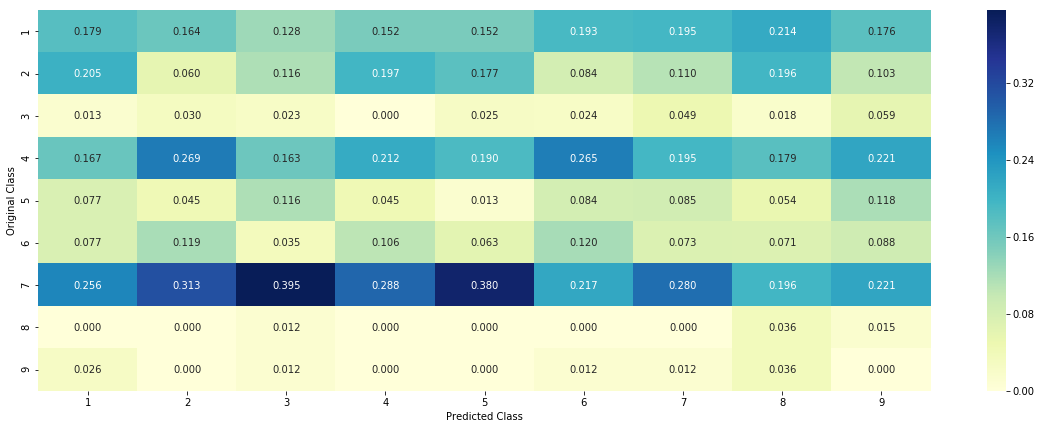

In [125]:
plt.figure(figsize=(20,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

## Recall Matrix

In [127]:
A =(((C.T)/(C.sum(axis=1))).T)

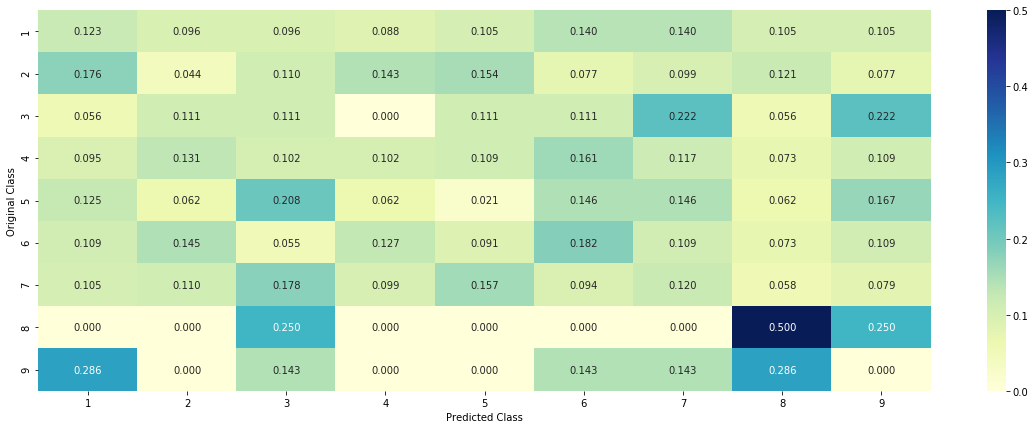

In [128]:
plt.figure(figsize=(20,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

## Evaluating Gene Column

Determining if the independent column gene is relevant to the target variable.

In [130]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])

# Top 10 genes
print(unique_genes.head(10))

Number of Unique Genes : 226
BRCA1     159
TP53      108
EGFR       92
BRCA2      84
PTEN       80
KIT        68
BRAF       61
ERBB2      46
ALK        42
PDGFRA     38
Name: Gene, dtype: int64


Cumulative distribution of unique Genes values

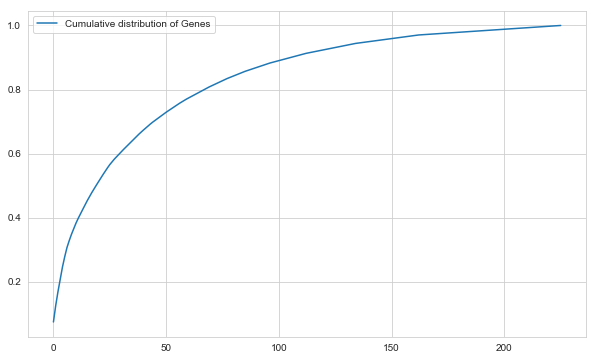

In [166]:
sns.set_style('whitegrid')
s = sum(unique_genes.values);
h = unique_genes.values/s;
c = np.cumsum(h)
plt.figure(figsize =(10,6))
plt.plot(c,label='Cumulative distribution of Genes')
plt.legend()
plt.show()

To convert this categorical variable to appropirate format machine learning algorithm will be used.

The 2 techniques to deal with it are:

1. ***One-hot encoding***
2. ***Response Encoding*** (Mean imputation)

In [136]:
# One-hot encoding of gene feature
gene_vectorizer = CountVectorizer()
# Train gene feature
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
# Test gene feature
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
# CV gene feature
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

### Column generated after one hot encoding

In [132]:
train_gene_feature_onehotCoding.shape

(2124, 225)

In [133]:
# Column names after one-hot encoding for gene column
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'asxl2',
 'atm',
 'aurka',
 'aurkb',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxa1',
 'foxl2',
 'foxp1',
 'gata3',
 'gli1',
 'gna11',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 'ikbke',
 'ikzf1',
 'jak1',
 'jak2',
 'jun'

Function for Response encoding of gene column

In [134]:
# Code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']

# ALGORITHIM
# -------------------------------------------------------------------------------------------------
# Considering all unique values and the number of occurences of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha /
#                                           number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there in train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ------------------------------------------------------------------------------------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict

def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to particular class
        # vec is 9 dimensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

### Response-coding of the gene feature

In [137]:
# Alpha is used for laplace smoothing
alpha = 1
# Train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# Test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# Cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

Columns after applying response encoding

In [138]:
train_gene_feature_responseCoding.shape

(2124, 9)

Determining if gene column is a good feature for predicting the target variable Class

In [140]:
# Hyperparemeter for SGD(Stochastic Gradient Descent) classifier
alpha = [10 ** x for x in range(-5, 1)]

# Using SGD classifier
# Using Calibrated Classifier to get the result into probablity format to be used for log loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.4055710815243176
For values of alpha =  0.0001 The log loss is: 1.2302867131769875
For values of alpha =  0.001 The log loss is: 1.2464927957354426
For values of alpha =  0.01 The log loss is: 1.3550051153609954
For values of alpha =  0.1 The log loss is: 1.4355357004098572
For values of alpha =  1 The log loss is: 1.461097715464573


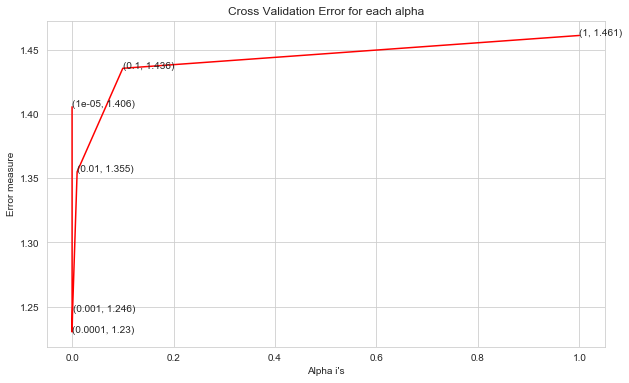

In [154]:
# Determining the best Alpha value
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize =(10,6))
ax.plot(alpha, cv_log_error_array,c='red')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [155]:
# Using best alpha value from the above graph to compute log loss
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.0001 The train log loss is: 1.0282875600898362
For values of best alpha =  0.0001 The cross validation log loss is: 1.2302867131769875
For values of best alpha =  0.0001 The test log loss is: 1.198488402951375


Checking overlapping between train, test or between validation and train

In [157]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

In [158]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 637 out of 665 : 95.78947368421052
2. In cross validation data 511 out of  532 : 96.05263157894737


## Evaluating Variation column

Variation is also a categorical variable and can be dealt with the same way as Gene column

In [159]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1926
Truncating_Mutations    60
Deletion                49
Amplification           48
Fusions                 20
T58I                     3
Q61L                     3
F28L                     2
G12A                     2
E17K                     2
E542K                    2
Name: Variation, dtype: int64


Cumulative distribution of unique variation values

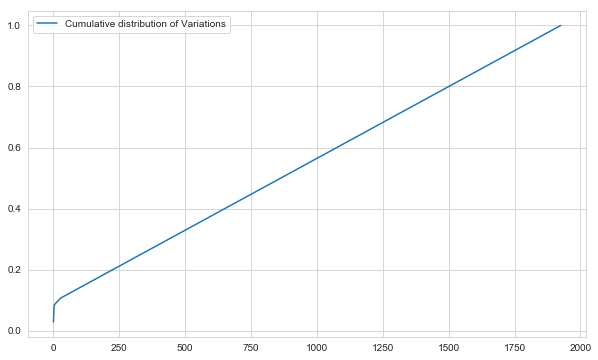

In [169]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
c = np.cumsum(h)
plt.figure(figsize = (10,6))
plt.plot(c,label='Cumulative distribution of Variations')
plt.legend()
plt.show()

Converting variation column using one hot encoder

In [173]:
# One-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

Shape of one hot encoder column for variation

In [171]:
train_variation_feature_onehotCoding.shape

(2124, 1954)

Generating response encoding for variation column

In [172]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

Shape of response encoding result

In [174]:
train_variation_feature_responseCoding.shape

(2124, 9)

Building the model with variation column

In [177]:
# Hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

# Using SGD classifier
# Using Calibrated Classifier to get the result into probablity format t be used for log loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.7217180162459338
For values of alpha =  0.0001 The log loss is: 1.7178509307262437
For values of alpha =  0.001 The log loss is: 1.7194506635109261
For values of alpha =  0.01 The log loss is: 1.729681868415084
For values of alpha =  0.1 The log loss is: 1.7471003505310512
For values of alpha =  1 The log loss is: 1.747467939835447


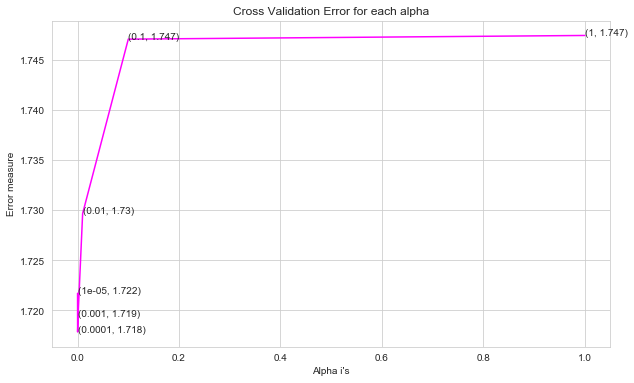

In [181]:
# Plot to check the best Alpha value
fig, ax = plt.subplots(figsize =(10,6))
ax.plot(alpha, cv_log_error_array,c='magenta')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [182]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.7489279919969108
For values of best alpha =  0.0001 The cross validation log loss is: 1.7178509307262437
For values of best alpha =  0.0001 The test log loss is: 1.6991247484700873


In [184]:
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 72 out of 665 : 10.827067669172932
2. In cross validation data 52 out of  532 : 9.774436090225564


## Evaluating Text column

In [186]:
# cls_text is a data frame
# for every row in data frame considering'TEXT'
# splitting the words by space
# making a dictionary with those words
# incrementing its count whenever that word is encountered

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [187]:
import math
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [188]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))

print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53230


In [189]:
dict_list = []
# dict_list =[] contains 9 dictionaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dictionary based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is build on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [190]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [193]:
# Converting each row value such that they sum to 1 
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [195]:
# Normalizing every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# Using the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])

# Normalizing every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# Using the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])

# Normalizing every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [196]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [197]:
# Number of words for a given frequency
print(Counter(sorted_text_occur))

Counter({3: 4751, 4: 3799, 5: 3205, 8: 2644, 6: 2527, 7: 2299, 9: 1519, 10: 1455, 12: 1239, 11: 1097, 14: 1016, 13: 876, 16: 842, 15: 800, 18: 792, 21: 602, 20: 589, 17: 572, 19: 528, 24: 506, 22: 445, 30: 362, 23: 359, 28: 354, 25: 354, 45: 350, 29: 335, 27: 332, 33: 321, 48: 314, 26: 301, 32: 281, 36: 274, 31: 243, 34: 238, 35: 237, 40: 220, 42: 215, 38: 211, 37: 195, 39: 192, 43: 184, 44: 183, 46: 178, 49: 172, 50: 171, 41: 170, 56: 167, 55: 166, 54: 143, 47: 141, 60: 140, 51: 140, 57: 133, 53: 131, 52: 129, 69: 122, 64: 118, 59: 113, 58: 111, 66: 106, 68: 105, 63: 105, 61: 105, 62: 104, 65: 103, 71: 98, 96: 92, 86: 91, 70: 90, 77: 89, 73: 87, 84: 85, 67: 85, 81: 84, 93: 80, 87: 80, 83: 80, 74: 80, 76: 77, 72: 77, 90: 76, 85: 74, 82: 72, 80: 68, 78: 68, 75: 68, 112: 67, 89: 65, 105: 64, 102: 64, 88: 64, 79: 63, 92: 62, 91: 59, 99: 58, 104: 57, 120: 56, 100: 52, 113: 51, 97: 51, 95: 51, 124: 50, 98: 49, 126: 48, 107: 47, 141: 45, 108: 45, 94: 45, 140: 44, 127: 44, 117: 44, 111: 43, 1

Building the model with text column

In [198]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.3782981575568671
For values of alpha =  0.0001 The log loss is: 1.3380449944966688
For values of alpha =  0.001 The log loss is: 1.2318402815637446
For values of alpha =  0.01 The log loss is: 1.3042767397672517
For values of alpha =  0.1 The log loss is: 1.5108757790915943
For values of alpha =  1 The log loss is: 1.706637492521324


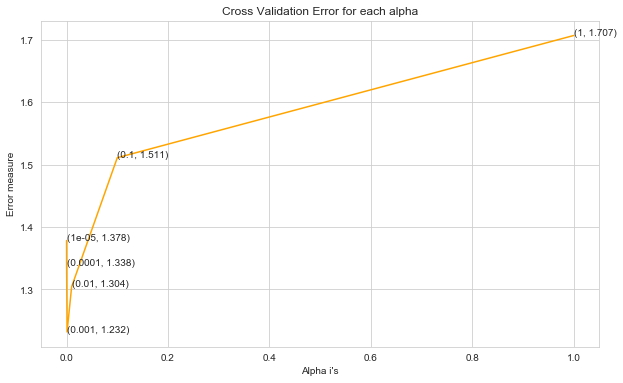

In [201]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(alpha, cv_log_error_array,c='orange')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [200]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.001 The train log loss is: 0.7483051408486111
For values of best alpha =  0.001 The cross validation log loss is: 1.2318402815637446
For values of best alpha =  0.001 The test log loss is: 1.1877940238419862


Checking the overlap of text data

In [202]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [203]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.384 % of word of test data appeared in train data
98.806 % of word of Cross Validation appeared in train data


Therefore, all 3 columns are going to be important.Gene column has less log loss with respect to the random model and 
good overlap. Variation column has less overlap but log loss is less with respect to the random model. Text column has 
high overlap and less log loss with respect to the random model.

## Data Preparation for Machine Learning models

Functions that will be used

In [204]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [355]:
# Used to plot the confusion matrices
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0)) 
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss an array of probabilities is provided that belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [207]:
# Function for naive bayes
# for the given indices,the name of the features would be printed
# and it would be checked  whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

## Combining all 3 features together

In [208]:
# Merging gene, variation and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

### One-hot encoding
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

### Response Encoding
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [211]:
print("One hot encoding features :")
print("(number of data points,number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points,number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points,number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points,number of features) in train data =  (2124, 55409)
(number of data points,number of features) in test data =  (665, 55409)
(number of data points,number of features) in cross validation data = (532, 55409)


In [212]:
print(" Response encoding features :")
print("(number of data points,number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points,number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points,number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points,number of features) in train data =  (2124, 27)
(number of data points,number of features) in test data =  (665, 27)
(number of data points,number of features) in cross validation data = (532, 27)


## Building Machine Learning models

### Naive Bayes

In [215]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("For alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # To avoid rounding error while multiplying probabilites log-probability estimates are being used
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

For alpha = 1e-05
Log Loss : 1.2587215805905274
For alpha = 0.0001
Log Loss : 1.2588335943566544
For alpha = 0.001
Log Loss : 1.2602122560937965
For alpha = 0.1
Log Loss : 1.2683919615784613
For alpha = 1
Log Loss : 1.2585949159712573
For alpha = 10
Log Loss : 1.3314404273737936
For alpha = 100
Log Loss : 1.3529976187934036
For alpha = 1000
Log Loss : 1.3281184449853183


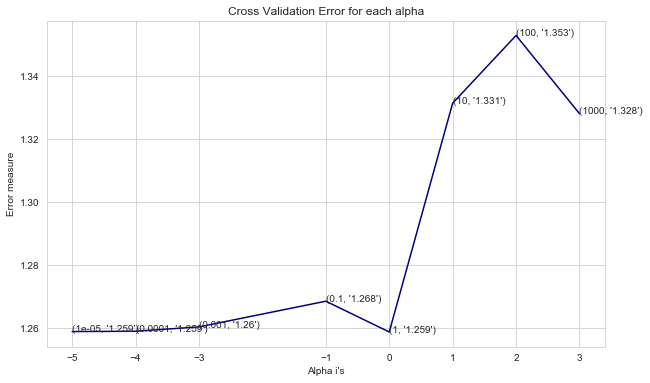

In [221]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(np.log10(alpha), cv_log_error_array,c='navy')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [222]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  1 The train log loss is: 0.9035395409579876
For values of best alpha =  1 The cross validation log loss is: 1.2585949159712573
For values of best alpha =  1 The test log loss is: 1.2783339153155862


#### Testing Naive Bayes model with best found value of alpha on testing data

Log Loss : 1.2585949159712573
Number of Misclassified points : 0.37030075187969924
-------------------- Confusion matrix --------------------


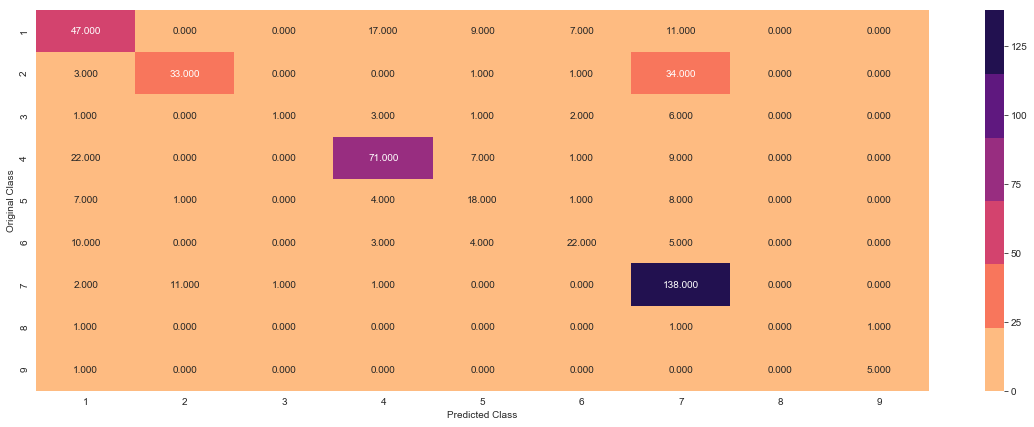

-------------------- Precision matrix (Columm Sum=1) --------------------


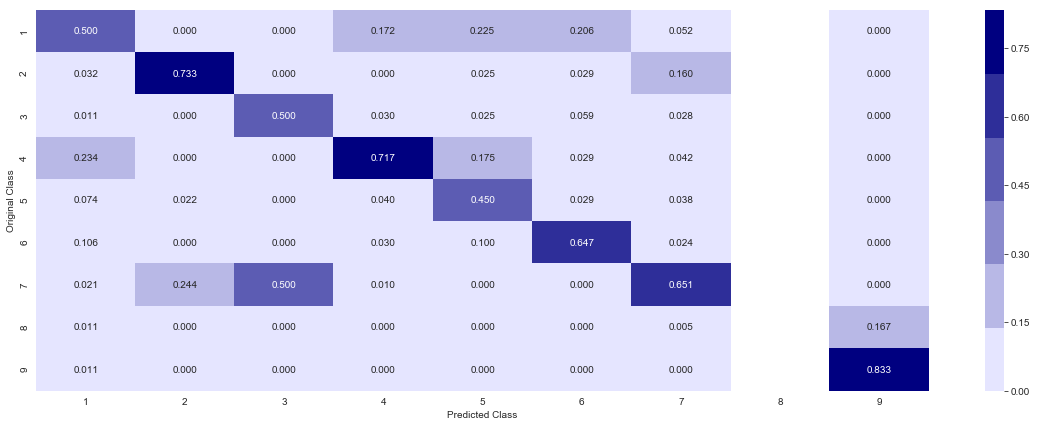

-------------------- Recall matrix (Row sum=1) --------------------


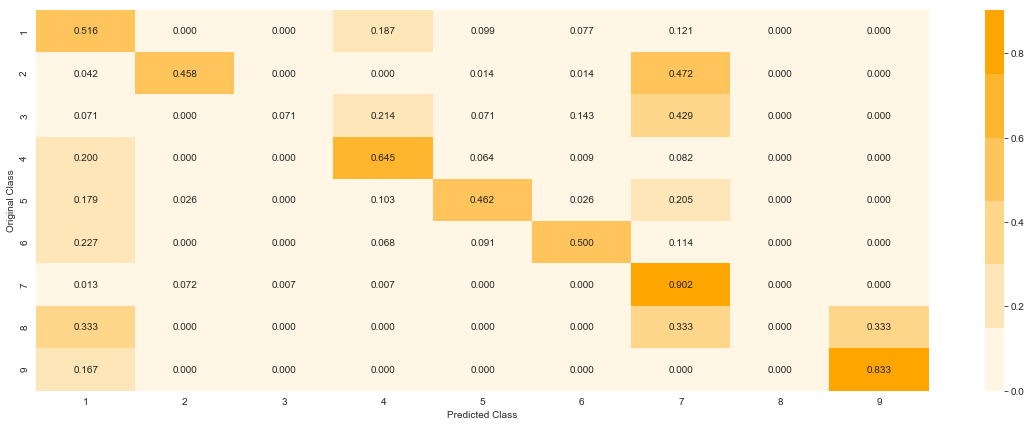

In [263]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of Misclassified points :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

### Interpretability of the model

In [264]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0691 0.0883 0.0218 0.0887 0.0478 0.0343 0.6403 0.0055 0.004 ]]
Actual Class : 4
--------------------------------------------------
19 Text feature [activating] present in test data point [True]
20 Text feature [kinase] present in test data point [True]
21 Text feature [presence] present in test data point [True]
22 Text feature [downstream] present in test data point [True]
23 Text feature [independent] present in test data point [True]
24 Text feature [contrast] present in test data point [True]
25 Text feature [activation] present in test data point [True]
26 Text feature [well] present in test data point [True]
27 Text feature [also] present in test data point [True]
28 Text feature [potential] present in test data point [True]
29 Text feature [expressing] present in test data point [True]
30 Text feature [cells] present in test data point [True]
31 Text feature [shown] present in test data point [True]
32 Text feature [inhibito

In [265]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0691 0.0883 0.0218 0.0887 0.0478 0.0343 0.6403 0.0055 0.004 ]]
Actual Class : 2
--------------------------------------------------
20 Text feature [kinase] present in test data point [True]
21 Text feature [presence] present in test data point [True]
22 Text feature [downstream] present in test data point [True]
23 Text feature [independent] present in test data point [True]
24 Text feature [contrast] present in test data point [True]
25 Text feature [activation] present in test data point [True]
26 Text feature [well] present in test data point [True]
27 Text feature [also] present in test data point [True]
28 Text feature [potential] present in test data point [True]
29 Text feature [expressing] present in test data point [True]
30 Text feature [cells] present in test data point [True]
31 Text feature [shown] present in test data point [True]
32 Text feature [inhibitor] present in test data point [True]
33 Text feature [growth] p

#### Naive Bayes is not performing very badly but lets look at other models

## K Nearest Neighbour Classification

In [268]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites log-probability estimates are being used
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 5
Log Loss : 1.1182133488834451
for alpha = 11
Log Loss : 1.0709333168229418
for alpha = 15
Log Loss : 1.0716697426937993
for alpha = 21
Log Loss : 1.084554143313158
for alpha = 31
Log Loss : 1.0916765459327602
for alpha = 41
Log Loss : 1.0962764946323083
for alpha = 51
Log Loss : 1.1103997059824504
for alpha = 99
Log Loss : 1.1341548728233857


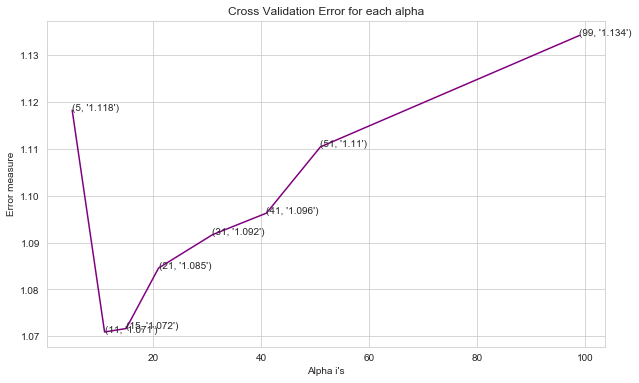

In [270]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(alpha, cv_log_error_array,c='purple')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [271]:
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  11 The train log loss is: 0.6432101792216272
For values of best alpha =  11 The cross validation log loss is: 1.0709333168229418
For values of best alpha =  11 The test log loss is: 1.0493756492423032


Testing the model on test dataset with our best alpha value

Log loss : 1.0709333168229418
Number of mis-classified points : 0.37969924812030076
-------------------- Confusion matrix --------------------


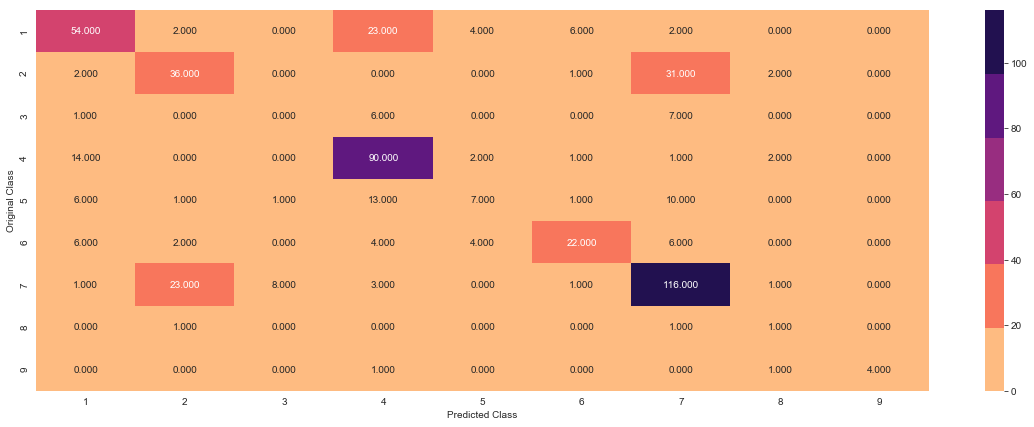

-------------------- Precision matrix (Columm Sum=1) --------------------


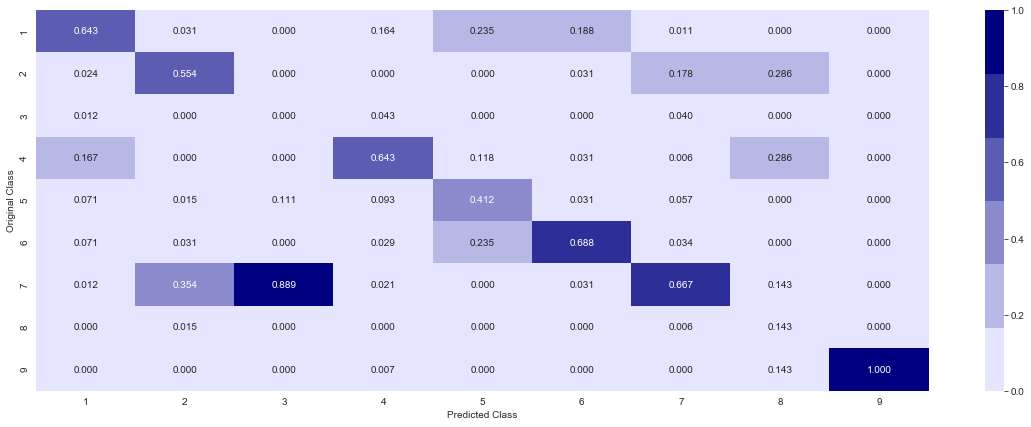

-------------------- Recall matrix (Row sum=1) --------------------


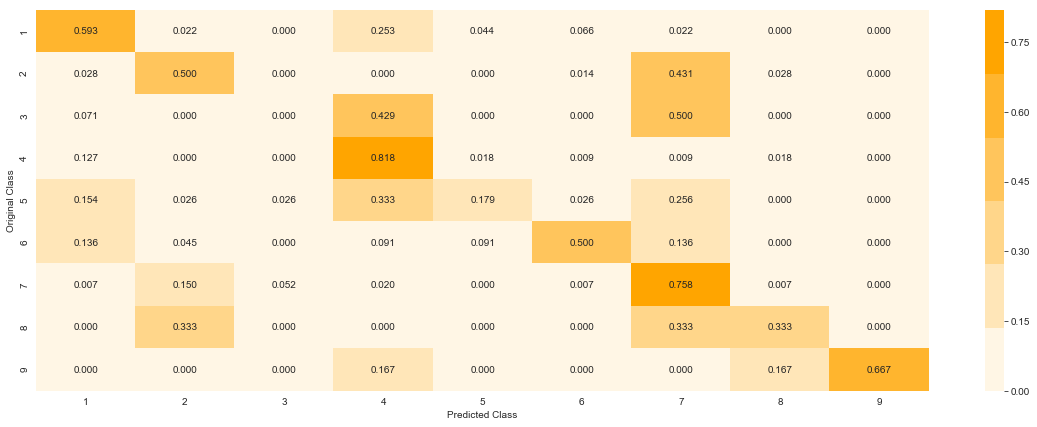

In [272]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

Testing some data points

In [282]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 6
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 5
Actual Class : 3
The  11  nearest neighbours of the test points belongs to classes [1 1 5 5 5 5 5 5 5 5 5]
Fequency of nearest points : Counter({5: 9, 1: 2})


In [278]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 105

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 1
the k value for knn is 11 and the nearest neighbours of the test points belongs to classes [3 1 1 3 1 4 1 1 4 4 1]
Fequency of nearest points : Counter({1: 6, 4: 3, 3: 2})


## Logistic Regression

#### Balancing all classes

In [284]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


For alpha = 1e-06
Log Loss : 1.4055285466124587
For alpha = 1e-05
Log Loss : 1.4014872588039995
For alpha = 0.0001
Log Loss : 1.3330020043373259
For alpha = 0.001
Log Loss : 1.1807922898667196
For alpha = 0.01
Log Loss : 1.210982508526201
For alpha = 0.1
Log Loss : 1.529975339380857
For alpha = 1
Log Loss : 1.7544268538852474
For alpha = 10
Log Loss : 1.773678654884074
For alpha = 100
Log Loss : 1.7755532044810098


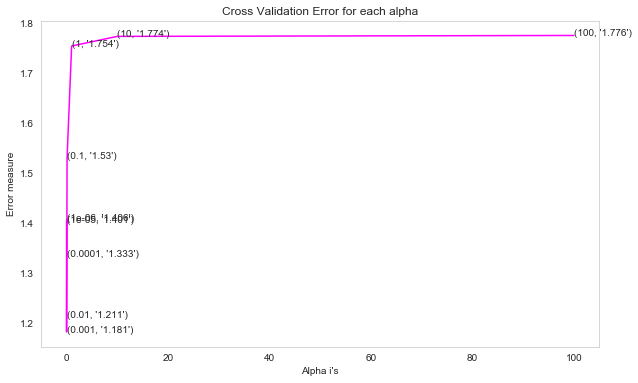

In [285]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(alpha, cv_log_error_array,c='magenta')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [286]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.6095303618208598
For values of best alpha =  0.001 The cross validation log loss is: 1.1807922898667196
For values of best alpha =  0.001 The test log loss is: 1.1165646251256747


### Testing on test data using best alpha value

Log loss : 1.1807922898667196
Number of mis-classified points : 0.34774436090225563
-------------------- Confusion matrix --------------------


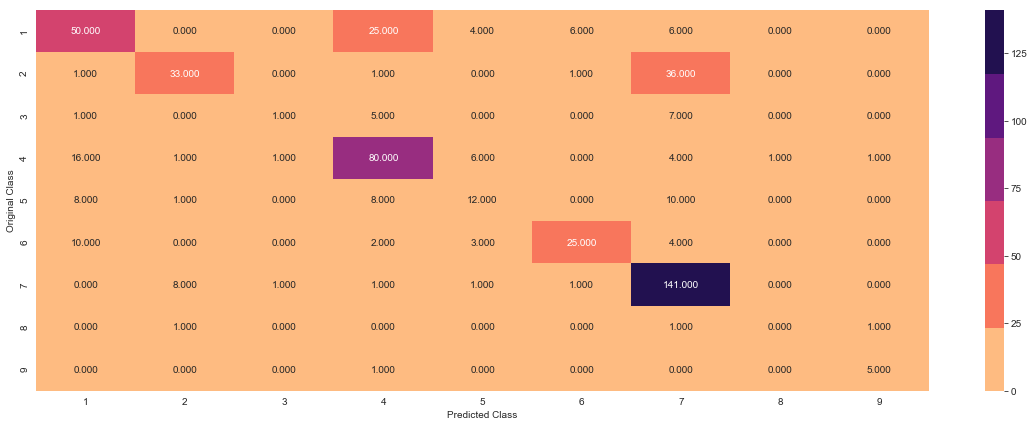

-------------------- Precision matrix (Columm Sum=1) --------------------


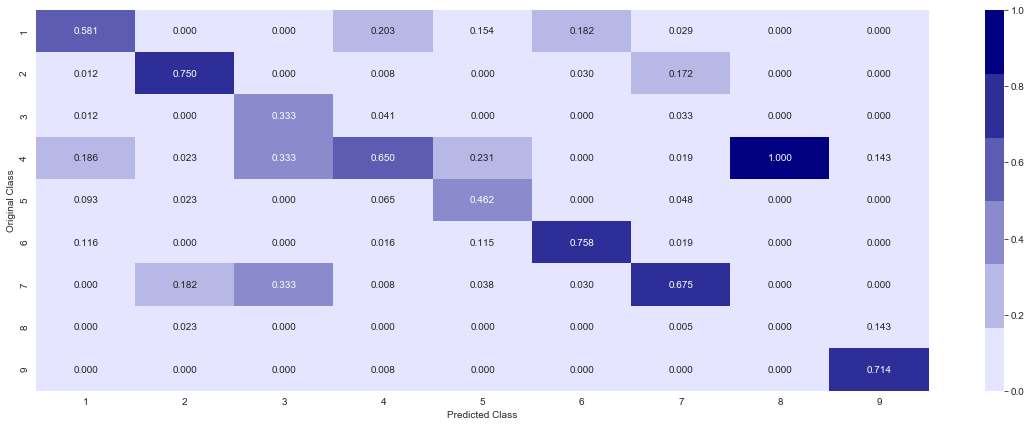

-------------------- Recall matrix (Row sum=1) --------------------


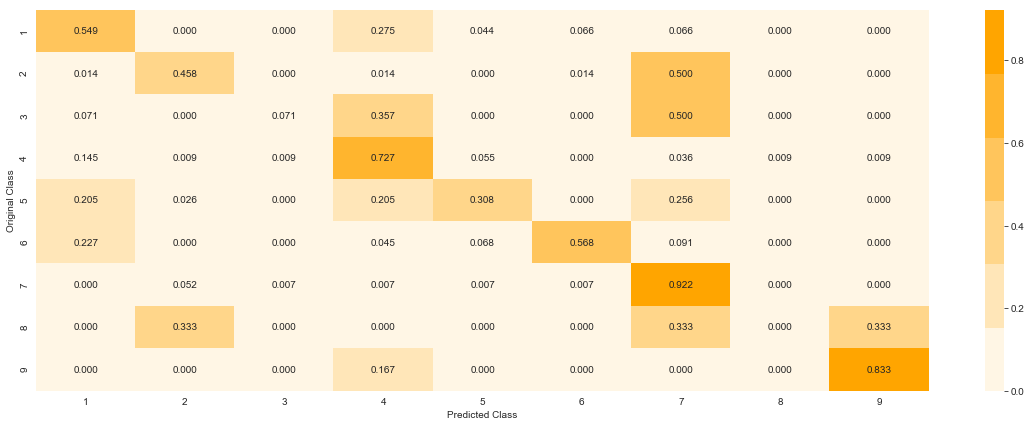

In [287]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### Feature importance

In [289]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

#### Testing query point and doing interpretability

In [292]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[1.900e-03 9.400e-03 2.400e-03 4.400e-03 2.000e-03 4.000e-04 9.711e-01
  6.000e-03 2.300e-03]]
Actual Class : 4
--------------------------------------------------
29 Text feature [constitutively] present in test data point [True]
31 Text feature [constitutive] present in test data point [True]
32 Text feature [transforming] present in test data point [True]
76 Text feature [oncogene] present in test data point [True]
93 Text feature [nude] present in test data point [True]
134 Text feature [transform] present in test data point [True]
150 Text feature [ligand] present in test data point [True]
173 Text feature [independence] present in test data point [True]
211 Text feature [transformed] present in test data point [True]
246 Text feature [4g10] present in test data point [True]
247 Text feature [oncogenes] present in test data point [True]
250 Text feature [erbbs] present in test data point [True]
251 Text feature [receptors] present

In [293]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0891 0.1668 0.0224 0.1083 0.0721 0.0532 0.4757 0.0052 0.0071]]
Actual Class : 2
--------------------------------------------------
76 Text feature [oncogene] present in test data point [True]
222 Text feature [phospho] present in test data point [True]
251 Text feature [receptors] present in test data point [True]
275 Text feature [expressing] present in test data point [True]
315 Text feature [cdnas] present in test data point [True]
360 Text feature [activation] present in test data point [True]
387 Text feature [activated] present in test data point [True]
390 Text feature [downstream] present in test data point [True]
429 Text feature [transformation] present in test data point [True]
455 Text feature [injection] present in test data point [True]
460 Text feature [relapsing] present in test data point [True]
Out of the top  500  features  11 are present in query point


### Without class balancing

In [294]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-06
Log Loss : 1.360983532083266
for alpha = 1e-05
Log Loss : 1.3641171080289343
for alpha = 0.0001
Log Loss : 1.3526132500565122
for alpha = 0.001
Log Loss : 1.193578484270829
for alpha = 0.01
Log Loss : 1.2506129833939896
for alpha = 0.1
Log Loss : 1.4343306221092447
for alpha = 1
Log Loss : 1.6521309427000401


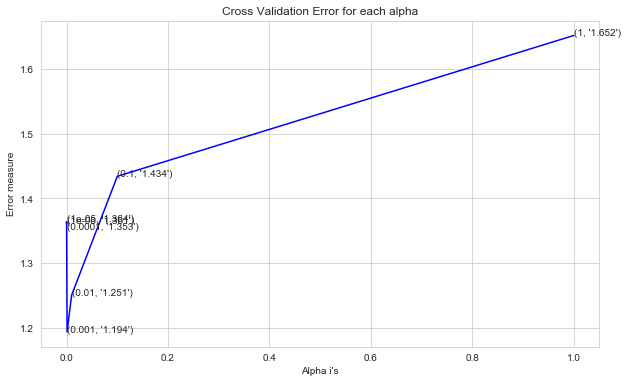

In [296]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(alpha, cv_log_error_array,c='blue')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [297]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.6095643861518412
For values of best alpha =  0.001 The cross validation log loss is: 1.193578484270829
For values of best alpha =  0.001 The test log loss is: 1.1163335269413523


### Testing the model with best hyper param

Log loss : 1.193578484270829
Number of mis-classified points : 0.33458646616541354
-------------------- Confusion matrix --------------------


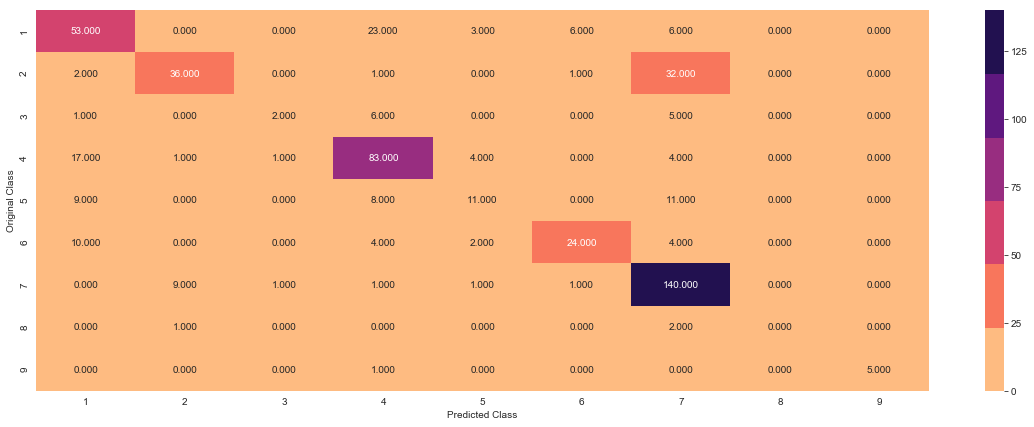

-------------------- Precision matrix (Columm Sum=1) --------------------


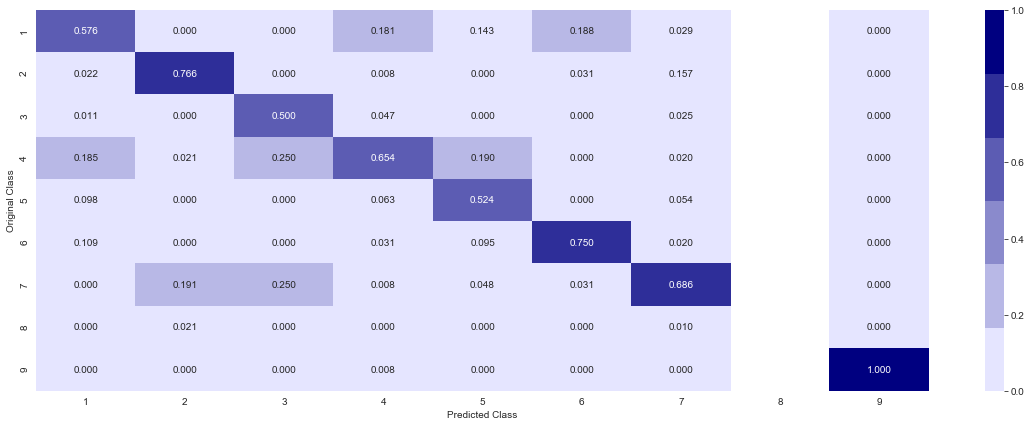

-------------------- Recall matrix (Row sum=1) --------------------


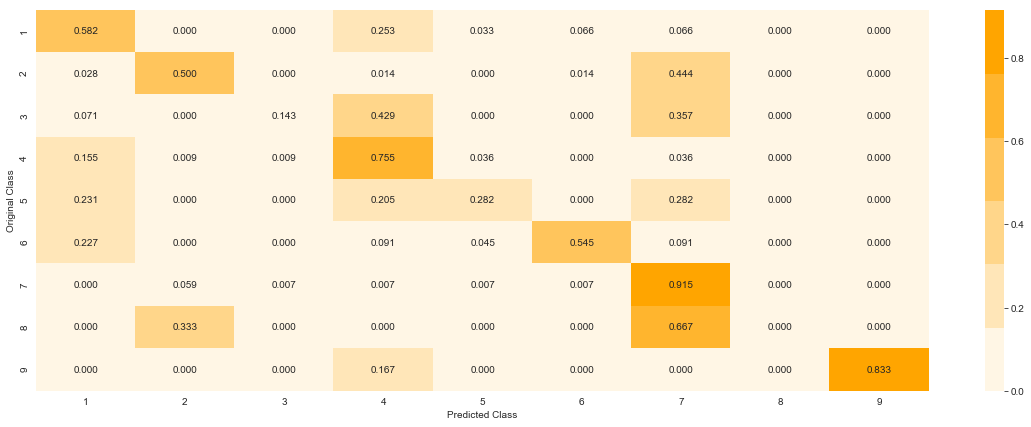

In [298]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### Testing query point and interpretability

In [300]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[2.600e-03 1.100e-02 1.000e-03 7.000e-03 1.400e-03 4.000e-04 9.715e-01
  5.000e-03 2.000e-04]]
Actual Class : 4
--------------------------------------------------
79 Text feature [transforming] present in test data point [True]
80 Text feature [constitutively] present in test data point [True]
98 Text feature [constitutive] present in test data point [True]
154 Text feature [independence] present in test data point [True]
187 Text feature [oncogene] present in test data point [True]
247 Text feature [transform] present in test data point [True]
252 Text feature [nude] present in test data point [True]
266 Text feature [expressing] present in test data point [True]
281 Text feature [transformed] present in test data point [True]
372 Text feature [4g10] present in test data point [True]
380 Text feature [ligand] present in test data point [True]
385 Text feature [transformation] present in test data point [True]
394 Text feature [erbbs]

## Linear Support Vector Machines

For C = 1e-05
Log Loss : 1.403631825227603
For C = 0.0001
Log Loss : 1.3760417346269633
For C = 0.001
Log Loss : 1.274215521532889
For C = 0.01
Log Loss : 1.1635684391834848
For C = 0.1
Log Loss : 1.4287519600998995
For C = 1
Log Loss : 1.764828412033484
For C = 10
Log Loss : 1.7758409909256003
For C = 100
Log Loss : 1.775841026624282


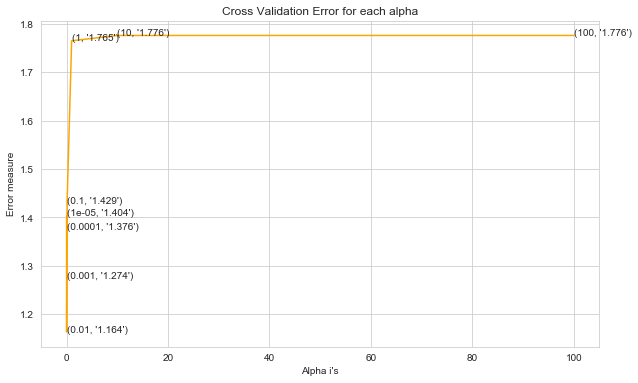

For values of best alpha =  0.01 The train log loss is: 0.7448942318139333
For values of best alpha =  0.01 The cross validation log loss is: 1.1635684391834848
For values of best alpha =  0.01 The test log loss is: 1.154494736853075


In [304]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("For C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(alpha, cv_log_error_array,c='orange')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### Querying some correctly classified point

In [305]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0148 0.0161 0.0043 0.0162 0.0071 0.0021 0.9327 0.005  0.0018]]
Actual Class : 4
--------------------------------------------------
27 Text feature [transforming] present in test data point [True]
39 Text feature [constitutively] present in test data point [True]
49 Text feature [cdnas] present in test data point [True]
51 Text feature [egf] present in test data point [True]
72 Text feature [expressing] present in test data point [True]
77 Text feature [nude] present in test data point [True]
78 Text feature [constitutive] present in test data point [True]
92 Text feature [transform] present in test data point [True]
100 Text feature [cysteine] present in test data point [True]
130 Text feature [independence] present in test data point [True]
131 Text feature [extracellular] present in test data point [True]
132 Text feature [ocum] present in test data point [True]
153 Text feature [oncogene] present in test data point [True]
173 Te

## Random Forest Classifier

### Model with One hot encoder

In [306]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for n_estimators = 100 and max depth =  5
Log Loss : 1.2606925326005618
for n_estimators = 100 and max depth =  10
Log Loss : 1.16970749826656
for n_estimators = 200 and max depth =  5
Log Loss : 1.2361747375002547
for n_estimators = 200 and max depth =  10
Log Loss : 1.1575253185583785
for n_estimators = 500 and max depth =  5
Log Loss : 1.2253766242622657
for n_estimators = 500 and max depth =  10
Log Loss : 1.1490316857986138
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2234386054802988
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1483889443236273
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2206508858420277
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1464311866321124


In [307]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best estimator =  2000 The train log loss is: 0.71554655587922
For values of best estimator =  2000 The cross validation log loss is: 1.1464311866321124
For values of best estimator =  2000 The test log loss is: 1.1833428098381533


### Testing on test data using best hyper param

Log loss : 1.1464311866321124
Number of mis-classified points : 0.38721804511278196
-------------------- Confusion matrix --------------------


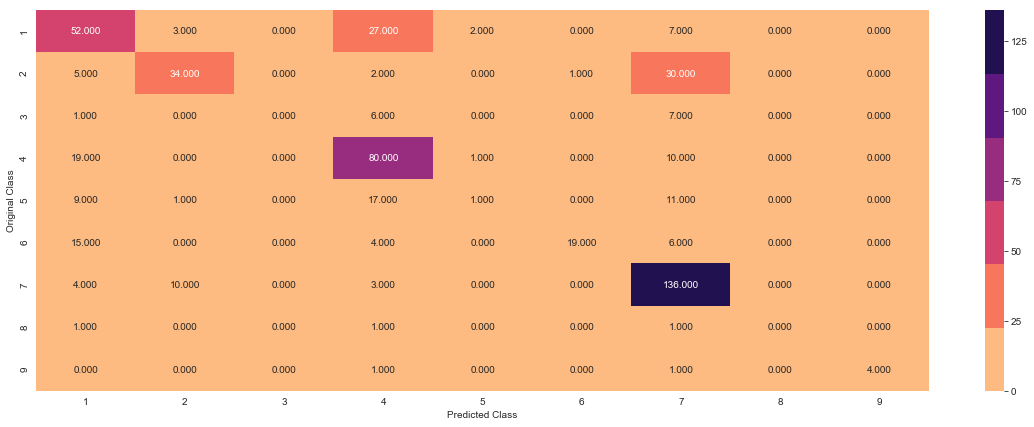

-------------------- Precision matrix (Columm Sum=1) --------------------


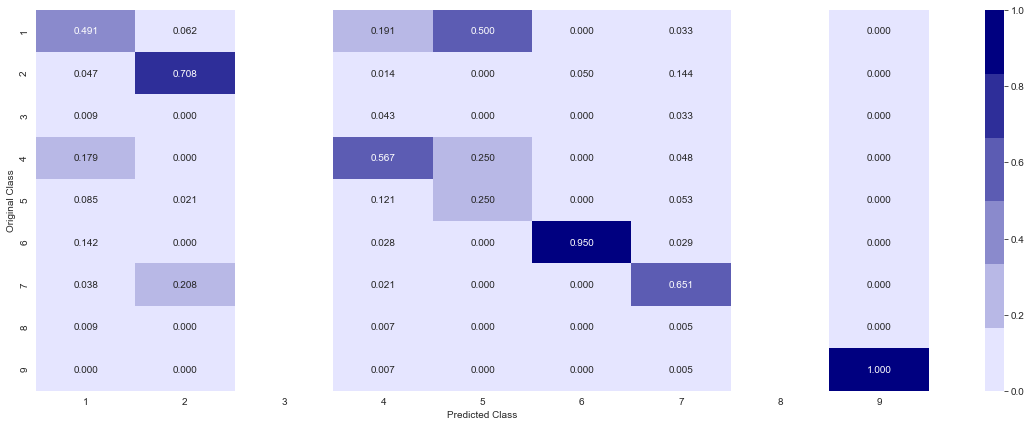

-------------------- Recall matrix (Row sum=1) --------------------


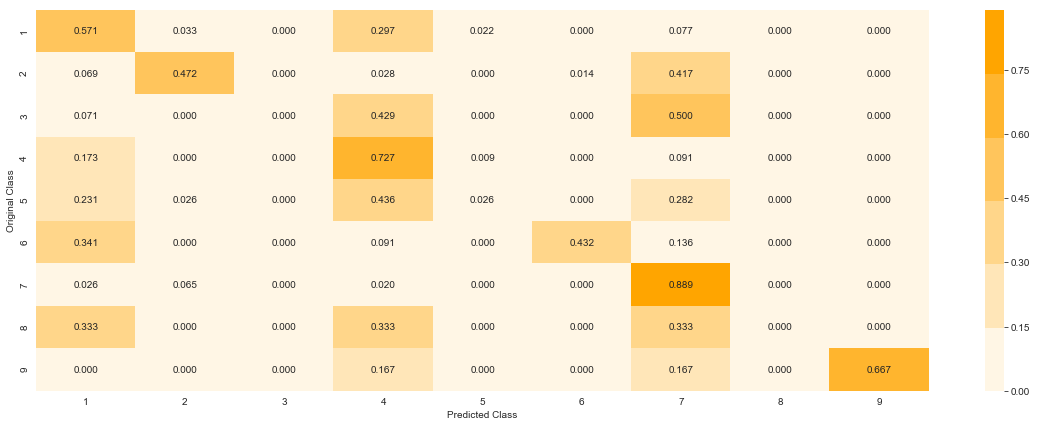

In [309]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [310]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0453 0.0843 0.0177 0.0481 0.0369 0.0291 0.7274 0.0053 0.0058]]
Actual Class : 4
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [tyrosine] present in test data point [True]
3 Text feature [inhibitors] present in test data point [True]
4 Text feature [activation] present in test data point [True]
5 Text feature [activated] present in test data point [True]
6 Text feature [constitutive] present in test data point [True]
7 Text feature [missense] present in test data point [True]
8 Text feature [phosphorylation] present in test data point [True]
10 Text feature [treatment] present in test data point [True]
11 Text feature [suppressor] present in test data point [True]
12 Text feature [inhibitor] present in test data point [True]
13 Text feature [signaling] present in test data point [True]
14 Text f

### Random Forest with Response Coding

In [311]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.1911084559839726
for n_estimators = 10 and max depth =  3
Log Loss : 1.7921997995269185
for n_estimators = 10 and max depth =  5
Log Loss : 1.6718363174376083
for n_estimators = 10 and max depth =  10
Log Loss : 1.9006581058877907
for n_estimators = 50 and max depth =  2
Log Loss : 1.7704907937479295
for n_estimators = 50 and max depth =  3
Log Loss : 1.530017210137907
for n_estimators = 50 and max depth =  5
Log Loss : 1.4497733801382338
for n_estimators = 50 and max depth =  10
Log Loss : 1.6701751696850011
for n_estimators = 100 and max depth =  2
Log Loss : 1.6445253008825975
for n_estimators = 100 and max depth =  3
Log Loss : 1.5594111390424084
for n_estimators = 100 and max depth =  5
Log Loss : 1.397258615740887
for n_estimators = 100 and max depth =  10
Log Loss : 1.5745248947407011
for n_estimators = 200 and max depth =  2
Log Loss : 1.73138449854515
for n_estimators = 200 and max depth =  3
Log Loss : 1.5986350034523786
f

### Testing model with best hyper param

Log loss : 1.3972586157408873
Number of mis-classified points : 0.5018796992481203
-------------------- Confusion matrix --------------------


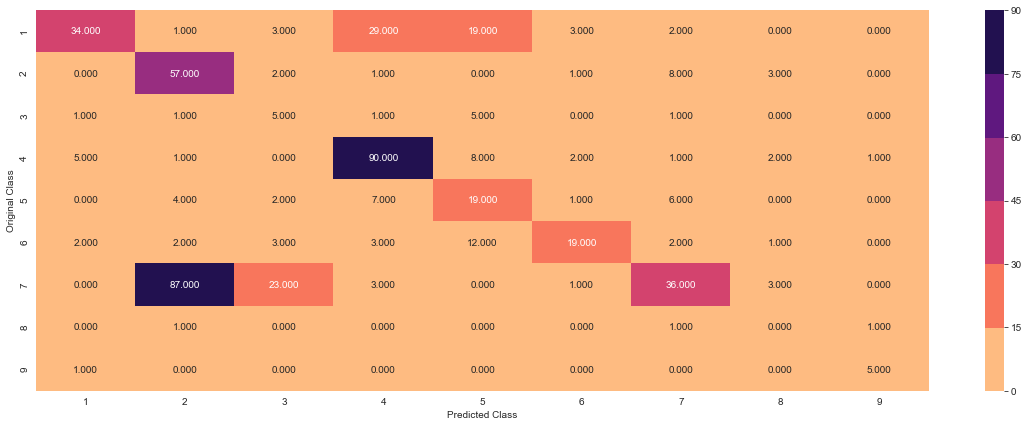

-------------------- Precision matrix (Columm Sum=1) --------------------


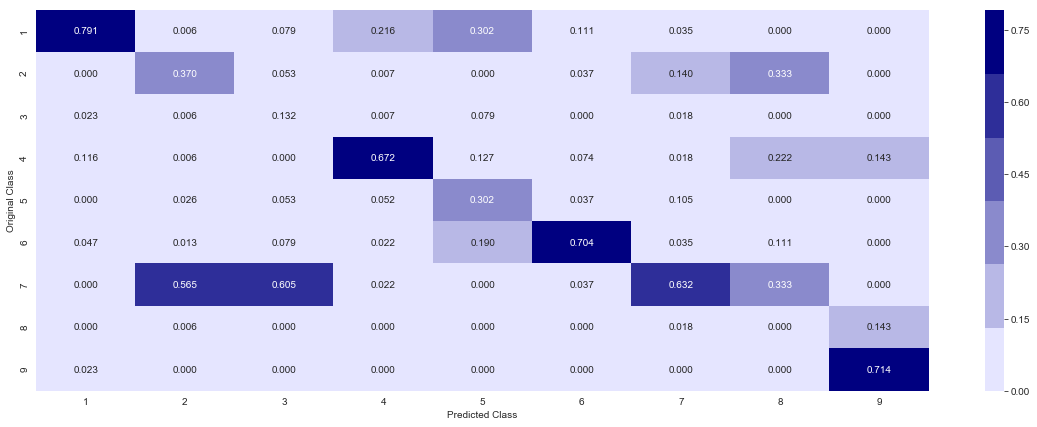

-------------------- Recall matrix (Row sum=1) --------------------


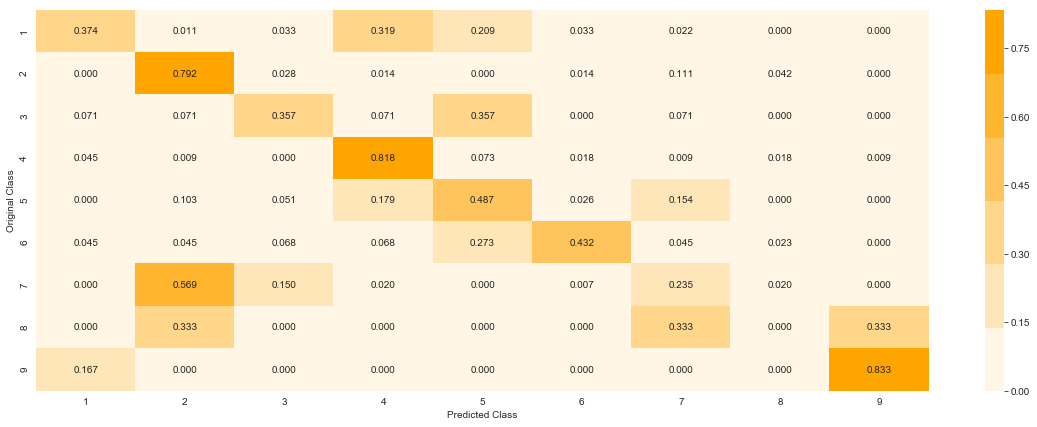

In [312]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

#### Query the classified point

In [313]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 7
Predicted Class Probabilities: [[0.0124 0.2309 0.2375 0.0239 0.0298 0.0678 0.3665 0.0155 0.0158]]
Actual Class : 4
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


## Stacking model

In [314]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.15
Support vector machines : Log Loss: 1.77
Naive Bayes : Log Loss: 1.26
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.178
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.040
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.520
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.105
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.181
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.412


#### Testing with best hyper param

Log loss (train) on the stacking classifier : 0.6581960205488411
Log loss (CV) on the stacking classifier : 1.1052866529093834
Log loss (test) on the stacking classifier : 1.1325245031593865
Number of misclassified point : 0.3609022556390977
-------------------- Confusion matrix --------------------


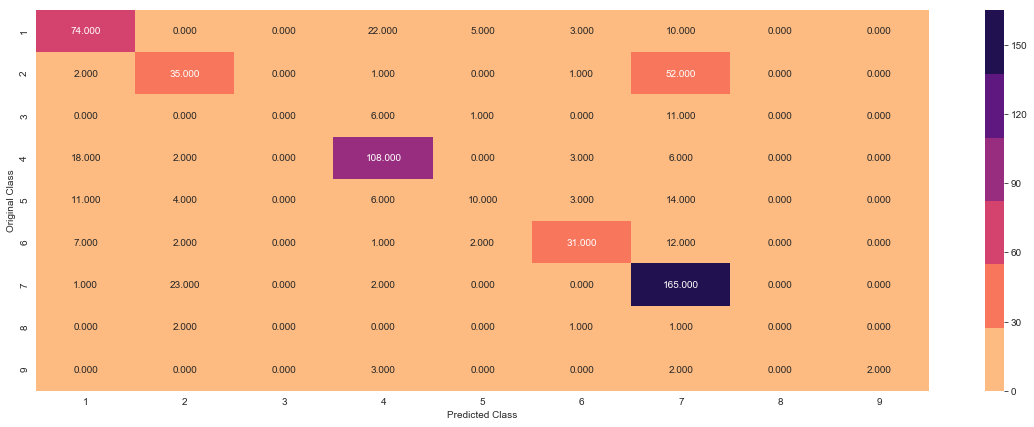

-------------------- Precision matrix (Columm Sum=1) --------------------


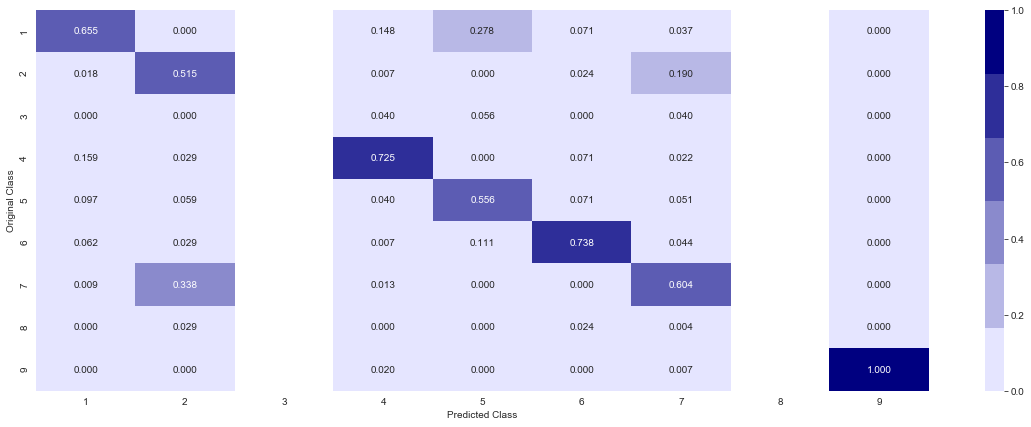

-------------------- Recall matrix (Row sum=1) --------------------


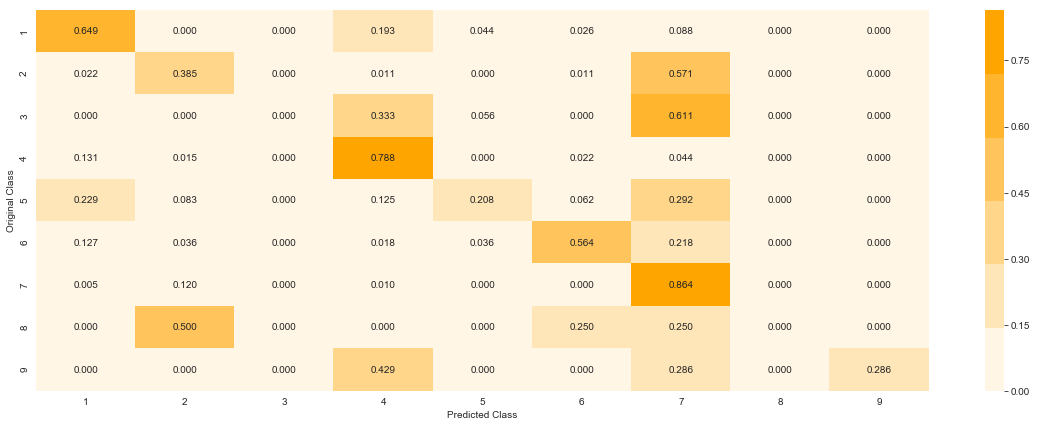

In [318]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of misclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

## Maximum voting Classifier

Log loss (train) on the VotingClassifier : 0.9161292780111124
Log loss (CV) on the VotingClassifier : 1.2112731424285728
Log loss (test) on the VotingClassifier : 1.2249457249960194
Number of missclassified point : 0.36541353383458647
-------------------- Confusion matrix --------------------


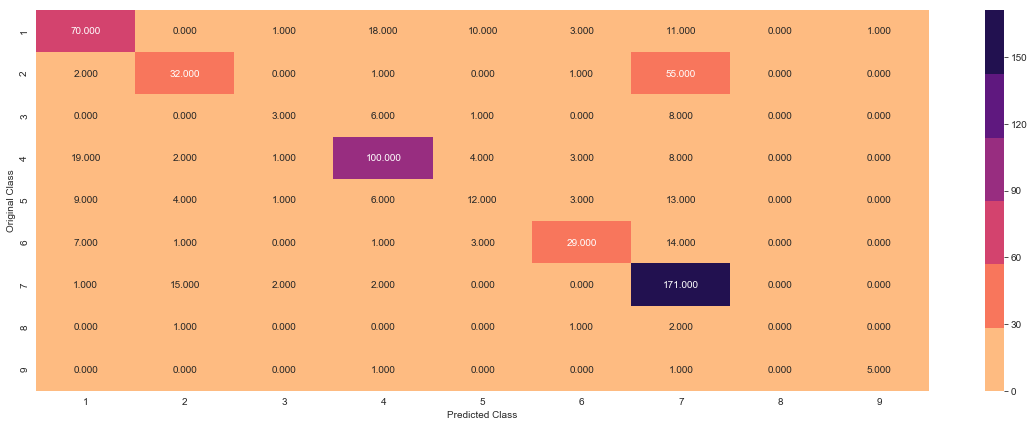

-------------------- Precision matrix (Columm Sum=1) --------------------


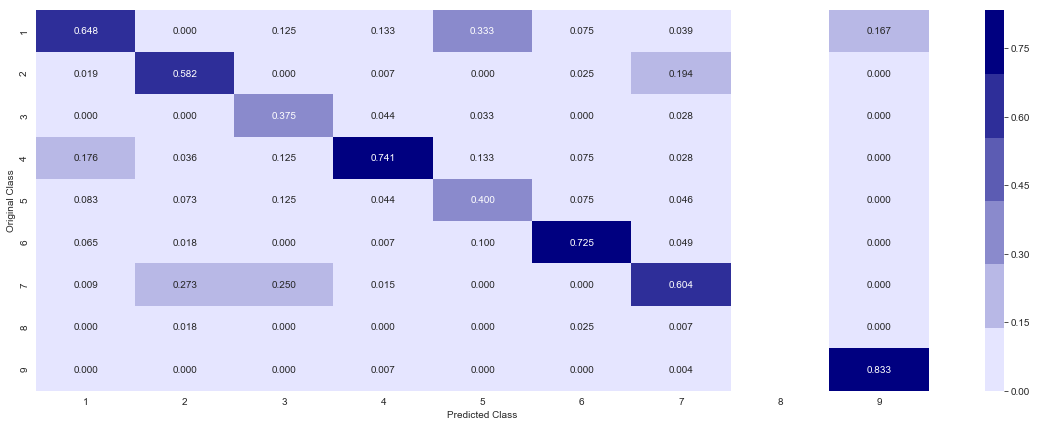

-------------------- Recall matrix (Row sum=1) --------------------


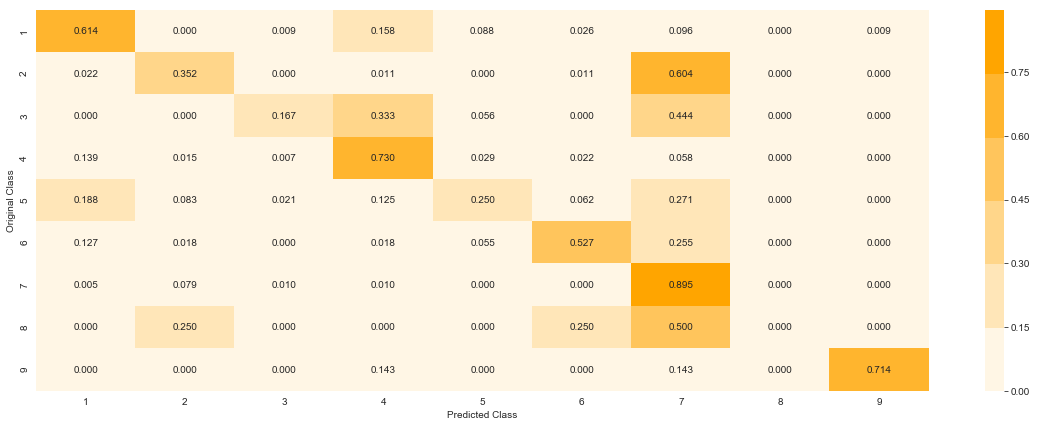

In [317]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

In [ ]:
X = 